# pycaret을 이용한 가스공급량 예측
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'
* 특성
    * 'month', '시간'으로 기온 예측
    * 기온, 기압, 습도 순서로 예측
    * 각 특성 예측 마다 앞에서 예측한 특성 활용
    * 공급량 예측(7개) : 'month', 'weekday', '시간', '구분', '기온', '기압', '습도'
* 2개 모델('lightgbm', 'catboost') 예측 평균
* 튜닝X, finalize_model X
* 구분별 훈련/예측
* 비율로 계산

## 자체평가
* 비교 대상 sub24_pycaret12.csv(제출 점수 : 0.1032155541)
* 자체점수가 NMAE = 0.69833, R2 = -8.06478 로 낮게 나옴.
    * 원인 : 훈련 특성에 day가 포함 안되어서 같은 요일의 값으로 훈련 되는 문제 발생.
    * 해결 : 훈련 특성에 day를 포함, weekday를 제거

In [1]:
# 제출 파일명 : sub25_pycaret13.csv
# 제출 점수 : 

## 데이터 가져오기
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'

In [1]:
from pycaret.regression import *

In [3]:
import time
import datetime
import pandas as pd
from tqdm import tqdm

### 2013-2018년 가스공급량과 기온, 습도, 기압 비율 자료 불러오기

In [4]:
total = pd.read_csv('../2013-2018년_가스공급량_기온_습도_기압_비율.csv')
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


### 2019년 데이터

In [5]:
test2019 = pd.read_csv('../data/test.csv')
test2019.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [6]:
test2019[['연월일', '시간', '구분']] = test2019['일자|시간|구분'].str.split(' ').tolist()
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A


In [7]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(test2019['구분'].unique()):
    d_map[d] = i
test2019['구분'] = test2019['구분'].map(d_map)
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,0
1,2019-01-01 02 A,2019-01-01,02,0
2,2019-01-01 03 A,2019-01-01,03,0
3,2019-01-01 04 A,2019-01-01,04,0
4,2019-01-01 05 A,2019-01-01,05,0


In [8]:
# 연월일 열은 object형이므로 년, 월, 일로 나눈다.
test2019['연월일'] = pd.to_datetime(test2019['연월일'])
test2019['year'] = test2019['연월일'].dt.year
test2019['month'] = test2019['연월일'].dt.month
test2019['day'] = test2019['연월일'].dt.day
test2019['weekday'] = test2019['연월일'].dt.weekday
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [10]:
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  object        
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 945.1+ KB


In [13]:
test2019['시간']= test2019['시간'].astype(int)
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  int32         
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(5), object(1)
memory usage: 886.1+ KB


## 2019년 기온 훈련/예측

In [9]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [11]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     368088 non-null  int64  
 1   month    368088 non-null  int64  
 2   day      368088 non-null  int64  
 3   weekday  368088 non-null  int64  
 4   시간       368088 non-null  int64  
 5   구분       368088 non-null  int64  
 6   공급량      368088 non-null  float64
 7   기온       368088 non-null  float64
 8   습도       368088 non-null  float64
 9   기압       368088 non-null  float64
 10  공급량비율    368088 non-null  float64
 11  기온비율     368046 non-null  float64
 12  습도비율     368088 non-null  float64
 13  기압비율     368088 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 39.3 MB


In [36]:
start = time.time()

# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '기온비율']]

# 학습 특성 : 'month', 'weekday', '시간'
# 타겟 특성 : '기온비율'
exp = setup(train, target='기온비율', silent=True, fold=7, fold_shuffle=True, verbose=False)

# 모델 생성
lgbm = create_model('lightgbm')
cat = create_model('catboost')

# 기온비율 예측
test = test2019[['month', 'weekday', '시간']]
temp2019_pred_lgbm = predict_model(lgbm, test)
temp2019_pred_cat = predict_model(cat, test)

# 두 모델 기온비율 예측 평균
temp2019_pred = (temp2019_pred_lgbm['Label'] + temp2019_pred_cat['Label']) / 2

# 2019년 예측 기온비율 열 추가
test2019['기온비율'] = temp2019_pred

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1578,0.3957,0.6291,0.0280,0.2086,1.3894
1,0.1680,0.4912,0.7008,0.0377,0.2192,1.3697
2,0.1682,0.5191,0.7205,0.0393,0.2177,1.3603
3,0.1696,0.5111,0.7149,0.0362,0.2214,1.3662
4,0.1614,0.4086,0.6392,0.0302,0.2114,1.3792
5,0.1681,0.4806,0.6932,0.0214,0.2207,1.3505
6,0.1647,0.4861,0.6972,0.0318,0.2184,1.3507
Mean,0.1654,0.4703,0.6850,0.0321,0.2168,1.3666
SD,0.0040,0.0450,0.0335,0.0058,0.0045,0.0133


0:02:54


In [37]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.022321
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.097542
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.113993
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.085194
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.088380


## 2019년 기압 훈련/예측

In [38]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [39]:
start = time.time()

# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '기온비율', '기압비율']]

# 학습 특성 : 'month', 'weekday', '시간', '기온비율'
# 타겟 특성 : '기압비율'
exp = setup(train, target='기압비율',silent=True, fold=7, fold_shuffle=True, verbose=False)

# 모델 생성
lgbm = create_model('lightgbm')
cat = create_model('catboost')

# 기압비율 예측
df = test2019[['month', 'weekday', '시간', '기온비율']]
pressure2019_pred_lgbm = predict_model(lgbm, data=df)
pressure2019_pred_cat = predict_model(cat, data=df)

# 두 모델 기압비율 예측 평균
pressure2019_pred = (pressure2019_pred_lgbm['Label'] + pressure2019_pred_cat['Label']) / 2

# 2019년 예측 기압비율 열 추가
test2019['기압비율'] = pressure2019_pred

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0003,0.0000,0.0003,0.4573,0.0003,0.8577
1,0.0003,0.0000,0.0003,0.4606,0.0003,0.8583
2,0.0003,0.0000,0.0003,0.4547,0.0003,0.8647
3,0.0003,0.0000,0.0003,0.4560,0.0003,0.8566
4,0.0003,0.0000,0.0003,0.4575,0.0003,0.8653
5,0.0003,0.0000,0.0003,0.4671,0.0003,0.8512
6,0.0003,0.0000,0.0003,0.4557,0.0003,0.8596
Mean,0.0003,0.0000,0.0003,0.4584,0.0003,0.8591
SD,0.0000,0.0000,0.0000,0.0040,0.0000,0.0045


0:02:57


In [40]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.022321,0.000009
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.097542,-0.000030
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.113993,-0.000013
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.085194,-0.000099
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.088380,0.000047


## 2019년 습도(Humidity) 훈련/예측

In [41]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [42]:
start = time.time()

# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '기온비율','기압비율', '습도비율']]

# 학습 특성 : 'month', 'weekday', '시간', '기온비율', '기압비율'
# 타겟 특성 : '습도비율'
exp = setup(train, target='습도비율', fold=7, fold_shuffle=True, silent=True, verbose=False)

# 모델 생성
lgbm = create_model('lightgbm')
cat = create_model('catboost')

# 습도비율 예측
df = test2019[['month', 'weekday', '시간', '기온비율', '기압비율']]
humidity2019_pred_lgbm = predict_model(lgbm, data=df)
humidity2019_pred_cat = predict_model(cat, data=df)

# 두 모델 습도비율 예측 평균
humidity2019_pred = (humidity2019_pred_lgbm['Label'] + humidity2019_pred_cat['Label']) / 2

# 2019년 예측 습도비율 열 추가
test2019['습도비율'] = humidity2019_pred

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0488,0.0056,0.0745,0.5040,0.0575,0.8751
1,0.0488,0.0058,0.0760,0.5102,0.0582,0.8755
2,0.0487,0.0057,0.0755,0.5022,0.0582,0.8754
3,0.0485,0.0055,0.0743,0.4939,0.0574,0.8801
4,0.0490,0.0060,0.0778,0.4982,0.0595,0.8726
5,0.0486,0.0057,0.0755,0.5003,0.0577,0.8761
6,0.0484,0.0056,0.0751,0.5041,0.0581,0.8649
Mean,0.0487,0.0057,0.0755,0.5018,0.0581,0.8742
SD,0.0002,0.0002,0.0011,0.0048,0.0007,0.0043


0:02:54


In [43]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.022321,0.000009,0.010126
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.097542,-0.000030,0.019389
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.113993,-0.000013,0.016771
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.085194,-0.000099,0.020389
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.088380,0.000047,0.022697


## 2019년 가스 공급량 훈련/예측
* 구분별로 예측하기(구분 7개)

### 공급량비율로 진행

In [44]:
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  int32         
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
 8   기온비율      15120 non-null  float64       
 9   기압비율      15120 non-null  float64       
 10  습도비율      15120 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(5), object(1)
memory usage: 1.2+ MB


In [45]:
test2019['구분'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [46]:
test2019.head(30)

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.022321,0.000009,0.010126
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.097542,-0.000030,0.019389
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.113993,-0.000013,0.016771
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.085194,-0.000099,0.020389
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.088380,0.000047,0.022697
5,2019-01-01 06 A,2019-01-01,6,0,2019,1,1,1,0.056217,0.000145,0.024024
6,2019-01-01 07 A,2019-01-01,7,0,2019,1,1,1,0.230159,0.000382,0.003594
7,2019-01-01 08 A,2019-01-01,8,0,2019,1,1,1,0.047785,0.000383,-0.005705
8,2019-01-01 09 A,2019-01-01,9,0,2019,1,1,1,0.021078,0.000371,-0.000367
9,2019-01-01 10 A,2019-01-01,10,0,2019,1,1,1,-0.222920,0.000297,-0.105542


In [47]:
test2019[test2019['구분'] == 0]

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.022321,0.000009,0.010126
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.097542,-0.000030,0.019389
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.113993,-0.000013,0.016771
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.085194,-0.000099,0.020389
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.088380,0.000047,0.022697
...,...,...,...,...,...,...,...,...,...,...,...
2155,2019-03-31 20 A,2019-03-31,20,0,2019,3,31,6,-0.136253,0.000406,0.123195
2156,2019-03-31 21 A,2019-03-31,21,0,2019,3,31,6,-0.110100,0.000276,0.065968
2157,2019-03-31 22 A,2019-03-31,22,0,2019,3,31,6,0.193860,0.000275,0.035518
2158,2019-03-31 23 A,2019-03-31,23,0,2019,3,31,6,-0.073230,0.000021,0.058134


In [48]:
test2019[test2019['구분'] == 1]

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
2160,2019-01-01 01 B,2019-01-01,1,1,2019,1,1,1,0.022321,0.000009,0.010126
2161,2019-01-01 02 B,2019-01-01,2,1,2019,1,1,1,-0.097542,-0.000030,0.019389
2162,2019-01-01 03 B,2019-01-01,3,1,2019,1,1,1,-0.113993,-0.000013,0.016771
2163,2019-01-01 04 B,2019-01-01,4,1,2019,1,1,1,0.085194,-0.000099,0.020389
2164,2019-01-01 05 B,2019-01-01,5,1,2019,1,1,1,0.088380,0.000047,0.022697
...,...,...,...,...,...,...,...,...,...,...,...
4315,2019-03-31 20 B,2019-03-31,20,1,2019,3,31,6,-0.136253,0.000406,0.123195
4316,2019-03-31 21 B,2019-03-31,21,1,2019,3,31,6,-0.110100,0.000276,0.065968
4317,2019-03-31 22 B,2019-03-31,22,1,2019,3,31,6,0.193860,0.000275,0.035518
4318,2019-03-31 23 B,2019-03-31,23,1,2019,3,31,6,-0.073230,0.000021,0.058134


In [49]:
total[total['구분'] == 1].reset_index(drop=True)

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,1,2051.733,-8.4,60.0,1009.4,-0.054106,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,1,1923.253,-8.1,58.0,1009.2,-0.062620,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,1,1927.253,-8.2,58.0,1008.2,0.002080,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,1,2047.333,-8.2,61.0,1007.3,0.062306,-0.000000,0.051724,-0.000893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2018,12,31,0,20,1,2668.688,-3.7,39.0,1024.9,0.026211,0.193548,-0.093023,-0.000585
52580,2018,12,31,0,21,1,2606.681,-4.6,44.0,1024.8,-0.023235,0.243243,0.128205,-0.000098
52581,2018,12,31,0,22,1,2540.169,-5.4,46.0,1024.4,-0.025516,0.173913,0.045455,-0.000390
52582,2018,12,31,0,23,1,2407.945,-5.2,47.0,1024.6,-0.052053,-0.037037,0.021739,0.000195


In [50]:
test2019

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.022321,0.000009,0.010126
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.097542,-0.000030,0.019389
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.113993,-0.000013,0.016771
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.085194,-0.000099,0.020389
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.088380,0.000047,0.022697
...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,6,2019,3,31,6,-0.136253,0.000406,0.123195
15116,2019-03-31 21 H,2019-03-31,21,6,2019,3,31,6,-0.110100,0.000276,0.065968
15117,2019-03-31 22 H,2019-03-31,22,6,2019,3,31,6,0.193860,0.000275,0.035518
15118,2019-03-31 23 H,2019-03-31,23,6,2019,3,31,6,-0.073230,0.000021,0.058134


### 구분에 따라 공급량비율 훈련/예측

In [51]:
# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '구분', '공급량비율', '기온비율', '기압비율', '습도비율']]

# 구분에 따라 예측하기
divisions = test2019['구분'].unique()

gas_rate_2019_pred = pd.DataFrame()
for division in tqdm(divisions):
    # 구분별 훈련, 테스트 셋 설정
    temp_train = train[train['구분'] == division].reset_index(drop=True)
    temp_test = test2019[test2019['구분'] == division].reset_index(drop=True)

    # 학습 특성 : 'month', 'weekday', '시간', '구분', '기온비율', '기압비율', '습도비율'
    # 타겟 특성 : '공급량비율'
    exp = setup(temp_train, target='공급량비율', silent=True, fold=7, fold_shuffle=True, verbose=False)

    # 모델 생성
    lgbm = create_model('lightgbm')
    cat = create_model('catboost')

    # 공급량비율 예측
    pop_test = temp_test[['month', 'weekday', '시간', '구분', '기온비율', '기압비율', '습도비율']]
    gas_rate_2019_pred_lgbm = predict_model(lgbm, data=pop_test)
    gas_rate_2019_pred_cat = predict_model(cat, data=pop_test)

    # 두 모델 공급량비율 예측 평균
    gas_rate_2019_division_pred = (gas_rate_2019_pred_lgbm['Label'] + gas_rate_2019_pred_cat['Label']) / 2

    # 구분별 예측 값 합치기
    gas_rate_2019_pred = pd.concat( [gas_rate_2019_pred, gas_rate_2019_division_pred], ignore_index=True )

# 2019년 예측 습도비율 열 추가
test2019['공급량비율'] = gas_rate_2019_pred

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0488,0.0071,0.0844,0.8658,0.0568,1.7908
1,0.0494,0.0098,0.0992,0.8173,0.0593,1.2282
2,0.0494,0.0074,0.0858,0.8602,0.0570,1.7050
3,0.0552,0.1169,0.3418,-0.1885,0.0785,1.3967
4,0.0564,0.3856,0.6210,0.0959,0.0754,1.6038
5,0.0480,0.0105,0.1025,0.8124,0.0570,1.4739
6,0.0529,0.0198,0.1409,0.6434,0.0653,1.4768
Mean,0.0514,0.0796,0.2108,0.5581,0.0642,1.5250
SD,0.0031,0.1302,0.1875,0.3957,0.0086,0.1768


100%|██████████| 7/7 [04:44<00:00, 40.58s/it]


In [54]:
# 예측 결과 확인
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율,공급량비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.022321,0.000009,0.010126,-0.094144
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.097542,-0.000030,0.019389,-0.133352
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.113993,-0.000013,0.016771,-0.077173
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.085194,-0.000099,0.020389,0.028134
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.088380,0.000047,0.022697,0.108541


In [55]:
test2019.tail()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율,공급량비율
15115,2019-03-31 20 H,2019-03-31,20,6,2019,3,31,6,-0.136253,0.000406,0.123195,0.119264
15116,2019-03-31 21 H,2019-03-31,21,6,2019,3,31,6,-0.110100,0.000276,0.065968,0.024092
15117,2019-03-31 22 H,2019-03-31,22,6,2019,3,31,6,0.193860,0.000275,0.035518,-0.057071
15118,2019-03-31 23 H,2019-03-31,23,6,2019,3,31,6,-0.073230,0.000021,0.058134,-0.088219
15119,2019-03-31 24 H,2019-03-31,24,6,2019,3,31,6,-0.065222,-0.000112,0.045782,-0.079867


In [57]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     368088 non-null  int64  
 1   month    368088 non-null  int64  
 2   day      368088 non-null  int64  
 3   weekday  368088 non-null  int64  
 4   시간       368088 non-null  int64  
 5   구분       368088 non-null  int64  
 6   공급량      368088 non-null  float64
 7   기온       368088 non-null  float64
 8   습도       368088 non-null  float64
 9   기압       368088 non-null  float64
 10  공급량비율    368088 non-null  float64
 11  기온비율     368046 non-null  float64
 12  습도비율     368088 non-null  float64
 13  기압비율     368088 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 39.3 MB


In [67]:
test2019[(test2019['month']==3) & (test2019['day']==31) & (test2019['구분'] == 6) & (test2019['시간'] == 20)]

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율,공급량비율
15115,2019-03-31 20 H,2019-03-31,20,6,2019,3,31,6,-0.136253,0.000406,0.123195,0.119264


In [68]:
total[(total['month']==3) & (total['weekday']==6) & (total['구분'] == 6) & (total['시간'] == 20)]

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
316987,2013,3,3,6,20,6,557.516,1.0,51.0,1011.2,0.119285,-0.230769,0.020000,0.000594
317155,2013,3,10,6,20,6,491.276,0.7,36.0,1013.4,0.173695,-0.611111,0.125000,0.001186
317323,2013,3,17,6,20,6,428.268,8.8,51.0,1000.2,0.117062,-0.128713,0.593750,-0.000100
317491,2013,3,24,6,20,6,476.516,5.3,46.0,1002.4,0.193163,-0.208955,0.179487,0.000999
317659,2013,3,31,6,20,6,422.220,7.1,37.0,1012.3,0.197842,-0.154762,0.193548,0.000890
325723,2014,3,2,6,20,6,449.356,5.0,36.0,1012.1,0.179028,-0.074074,-0.100000,0.000593
325891,2014,3,9,6,20,6,558.316,0.6,34.0,1011.8,0.205044,-0.600000,0.259259,0.001386
326059,2014,3,16,6,20,6,390.484,12.3,73.0,1010.4,0.240025,-0.095588,0.089552,0.000396
326227,2014,3,23,6,20,6,375.156,9.8,58.0,1016.8,0.237893,-0.075472,0.183673,0.000394
326395,2014,3,30,6,20,6,233.220,15.3,61.0,1002.7,0.201991,-0.067073,0.016667,0.001098


In [69]:
total[(total['month']==3) & (total['day']==31) & (total['구분'] == 6) & (total['시간'] == 20)]

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
317659,2013,3,31,6,20,6,422.220,7.1,37.0,1012.3,0.197842,-0.154762,0.193548,0.000890
326419,2014,3,31,0,20,6,243.300,15.4,35.0,1005.7,0.216427,-0.072289,0.129032,0.000497
335179,2015,3,31,1,20,6,335.660,13.2,84.0,1002.9,0.116440,-0.029412,0.024390,0.000499
343963,2016,3,31,3,20,6,271.828,14.8,20.0,1004.8,0.135209,-0.103030,-0.090909,0.000299
352723,2017,3,31,4,20,6,382.636,6.3,79.0,1007.4,0.076429,-0.086957,0.000000,0.000596
361483,2018,3,31,5,20,6,244.162,14.0,45.0,1008.1,0.113954,-0.084967,0.097561,0.000099


In [43]:
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  object        
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
 8   기온비율      15120 non-null  float64       
 9   기압비율      15120 non-null  float64       
 10  습도비율      15120 non-null  float64       
 11  공급량비율     15120 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 1.4+ MB


In [54]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [34]:
total.tail()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
368083,2018,12,31,0,20,6,681.033,-3.7,39.0,1024.9,0.003031,0.193548,-0.093023,-0.000585
368084,2018,12,31,0,21,6,669.961,-4.6,44.0,1024.8,-0.016258,0.243243,0.128205,-0.000098
368085,2018,12,31,0,22,6,657.941,-5.4,46.0,1024.4,-0.017941,0.173913,0.045455,-0.000390
368086,2018,12,31,0,23,6,610.953,-5.2,47.0,1024.6,-0.071417,-0.037037,0.021739,0.000195
368087,2018,12,31,0,24,6,560.896,-5.5,54.0,1024.1,-0.081933,0.057692,0.148936,-0.000488


### 공급량 비율 시각화

In [56]:
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

(array([3.68077e+05, 3.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([-0.99090417,  8.28090033, 17.55270482, 26.82450932, 36.09631381,
        45.36811831, 54.6399228 , 63.9117273 , 73.18353179, 82.45533629,
        91.72714078]),
 <BarContainer object of 10 artists>)

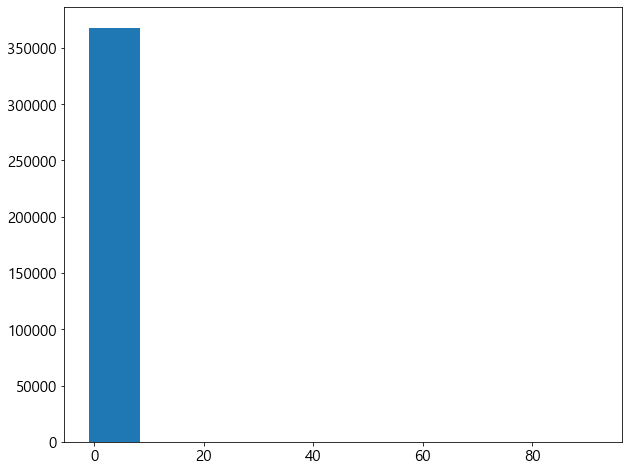

In [57]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량비율', data=total)

(array([2.140e+02, 1.278e+03, 5.706e+03, 3.489e+03, 2.086e+03, 1.553e+03,
        6.260e+02, 1.380e+02, 2.600e+01, 4.000e+00]),
 array([-0.25606991, -0.18086064, -0.10565137, -0.0304421 ,  0.04476717,
         0.11997644,  0.19518572,  0.27039499,  0.34560426,  0.42081353,
         0.4960228 ]),
 <BarContainer object of 10 artists>)

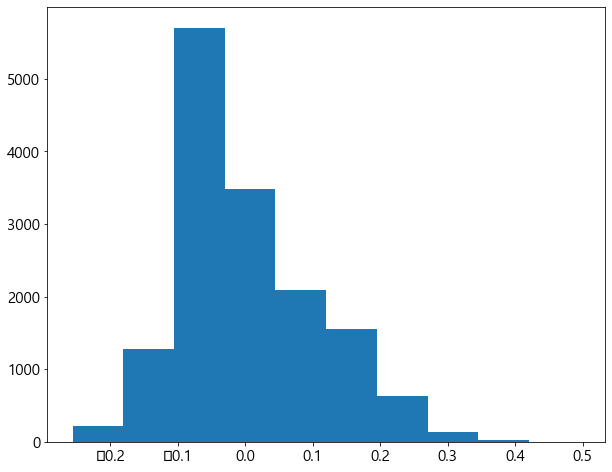

In [58]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량비율', data=test2019)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d61944f6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d61944fd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d61944f340>],
 'medians': [<matplotlib.lines.Line2D at 0x1d619445d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d619091070>],
 'means': []}

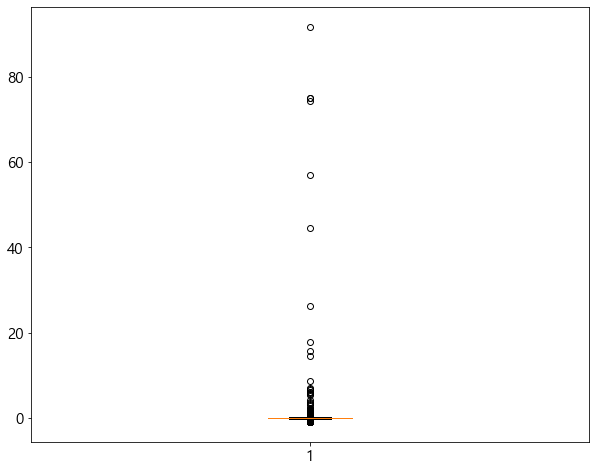

In [59]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='공급량비율', data=total)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d6199c3400>,
 'caps': [<matplotlib.lines.Line2D at 0x1d6199c3ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d6199c30a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d6199b4e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d6199c3d90>],
 'means': []}

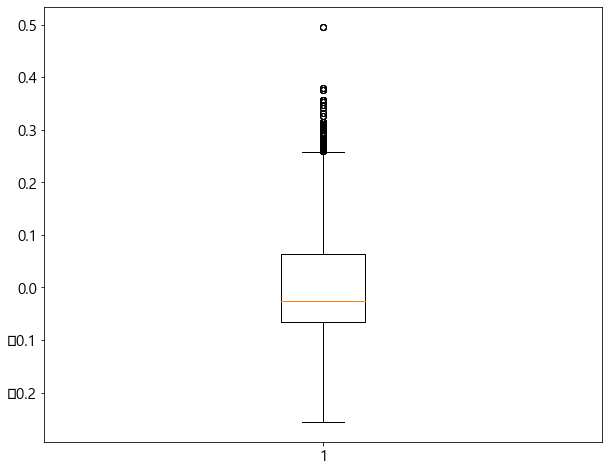

In [60]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='공급량비율', data=test2019)

<Figure size 864x576 with 0 Axes>

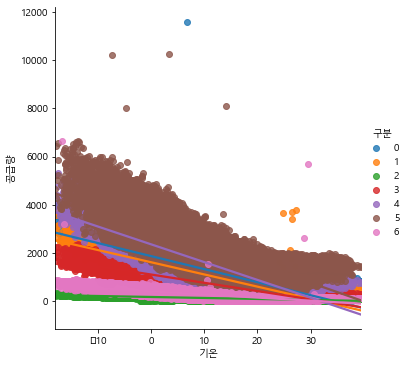

In [61]:
plt.figure(figsize=(12,8))
sns.lmplot(x='기온', y='공급량', hue='구분', data=total)

In [37]:
total.loc[368087,'공급량']

560.896

In [38]:
total.loc[368087, '공급량'] * 10

5608.959999999999

In [40]:
total.loc[(total['year']==2018) & (total['month']==12) & (total['day']==31) & (total['시간']==24), '공급량']

52583     2583.340
105167    2290.154
157751     237.911
210335    1422.478
262919    3534.260
315503    3982.757
368087     560.896
Name: 공급량, dtype: float64

In [41]:
total.iloc[-1,6]

560.896

In [42]:
total.iloc[-1,6] * 10

5608.959999999999

### 공급량비율로 공급량 구하기

In [44]:
# 전체 데이터에서 필요한 특성만 가져오기
train = total[['year', 'month', 'day', 'weekday', '시간', '구분', '공급량']]

# 구분에 따라 예측하기
divisions = test2019['구분'].unique()

total_gas = []
for division in tqdm(divisions):
    # 구분별 셋 설정
    temp_train = train[train['구분'] == division].reset_index(drop=True)
    temp_test = test2019[test2019['구분'] == division].reset_index(drop=True)

    # 2018년 12월 31일 24시 값
    one_div_gas = []
    temp_gas = temp_train.iloc[-1, 6]
    one_div_gas.append(temp_gas)
    
    # 해당일 공급량 = 전날 공급량 * ( 1 + 해당일 공급량 비율 )
    for i in range(len(temp_test['공급량비율'])):
        present_gas_rate = temp_test.loc[i, '공급량비율']
        present_gas = one_div_gas[-1] * ( 1 + present_gas_rate)
        one_div_gas.append(present_gas)
    
    # 첫번째 값은 2018년 12월 31일 24시 값이므로 제거
    one_div_gas.pop(0)

    # 구분 전체 가스공급량을 하나의 리스트에 저장
    total_gas += one_div_gas

100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


In [45]:
# 총 15120개
len(total_gas)

15120

## 제출 파일 만들기

In [47]:
sub = pd.read_csv('../data/sample_submission.csv')
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [48]:
sub.tail()

,일자|시간|구분,공급량
15115,2019-03-31 20 H,0
15116,2019-03-31 21 H,0
15117,2019-03-31 22 H,0
15118,2019-03-31 23 H,0
15119,2019-03-31 24 H,0


In [49]:
sub['공급량'] = total_gas
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2352.682383
1,2019-01-01 02 A,2041.490928
2,2019-01-01 03 A,1881.861443
3,2019-01-01 04 A,1932.579388
4,2019-01-01 05 A,2140.328256


In [52]:
sub.tail()

,일자|시간|구분,공급량
15115,2019-03-31 20 H,45.562802
15116,2019-03-31 21 H,46.523646
15117,2019-03-31 22 H,43.542370
15118,2019-03-31 23 H,39.489674
15119,2019-03-31 24 H,36.467242


In [50]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일자|시간|구분  15120 non-null  object 
 1   공급량       15120 non-null  float64
dtypes: float64(1), object(1)
memory usage: 236.4+ KB


In [51]:
sub.to_csv("sub25_pycaret13.csv", index=False)